In [11]:
# ------------------------------
#   Imports and setup
# ------------------------------
# Libraries for data handling and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Suppress warnings for clearer notebook output
import warnings
warnings.filterwarnings("ignore")

print("Libraries are loaded.")


Libraries are loaded.


In [12]:
# ------------------------------
#  Load dataset
# ------------------------------
# Path to the CSV file in the Colab environment
file_path = '/content/WA_Fn-UseC_-Telco-Customer-Churn.csv'

print("Loading dataset from:", file_path)
try:
    dataset = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("File not found. Please upload the CSV file to the Colab environment and retry.")
    raise

print("Dataset shape:", dataset.shape)
# Show a quick preview of the data
display(dataset.head())


Loading dataset from: /content/WA_Fn-UseC_-Telco-Customer-Churn.csv
Dataset loaded successfully.
Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paper

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000



Target distribution (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64


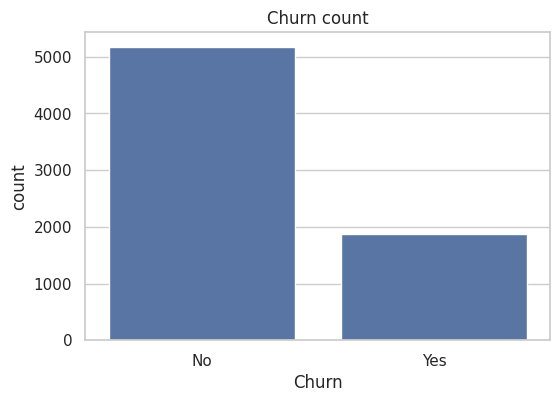

In [13]:
# ------------------------------
#   Initial inspection
# ------------------------------
# Quick overview: column types and basic statistics
print("Basic information about the dataset:")
dataset.info()

print("\nNumeric summary:")
display(dataset.describe())

print("\nTarget distribution (Churn):")
print(dataset['Churn'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=dataset)
plt.title("Churn count")
plt.show()


In [14]:
# ------------------------------
#  Handle missing values and types
# ------------------------------
# Some rows have 'TotalCharges' stored as blank strings; convert to numeric
if 'TotalCharges' in dataset.columns:
    dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')
    null_count = dataset['TotalCharges'].isnull().sum()
    print("Non-numeric or missing values in TotalCharges:", null_count)
    # Replace missing values with median to avoid bias from outliers
    dataset['TotalCharges'].fillna(dataset['TotalCharges'].median(), inplace=True)
    print("Missing TotalCharges replaced with median.")

print("\nMissing values per column after handling:")
print(dataset.isnull().sum())


Non-numeric or missing values in TotalCharges: 11
Missing TotalCharges replaced with median.

Missing values per column after handling:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [15]:
# ------------------------------
#   Remove unneeded columns
# ------------------------------
# customerID is an identifier and not useful for prediction, so remove it
if 'customerID' in dataset.columns:
    dataset.drop(columns=['customerID'], inplace=True)
    print("Removed 'customerID' column.")

print("Columns now:", dataset.columns.tolist())


Removed 'customerID' column.
Columns now: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


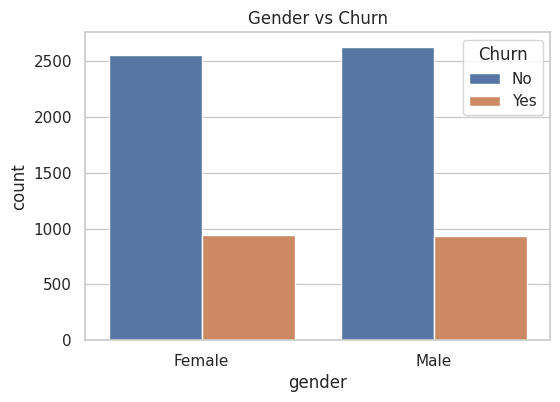

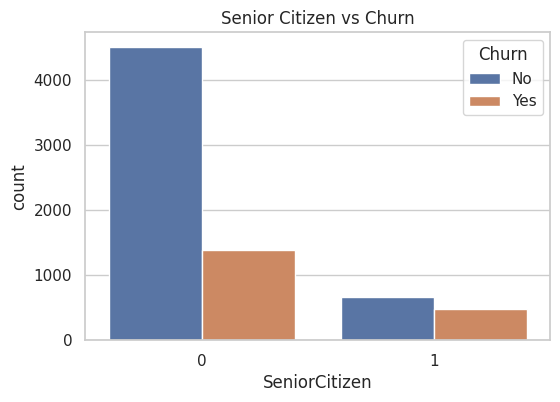

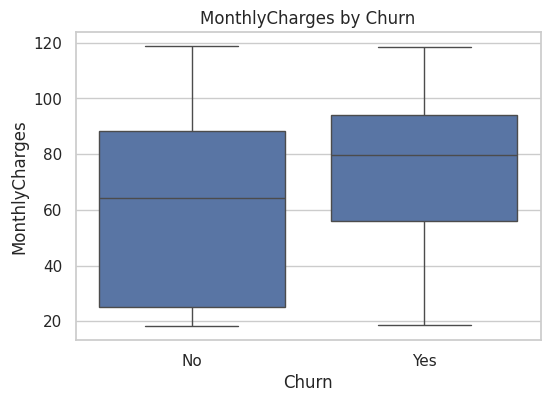

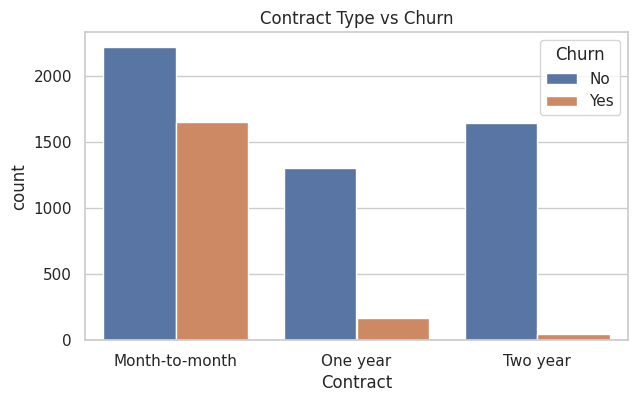

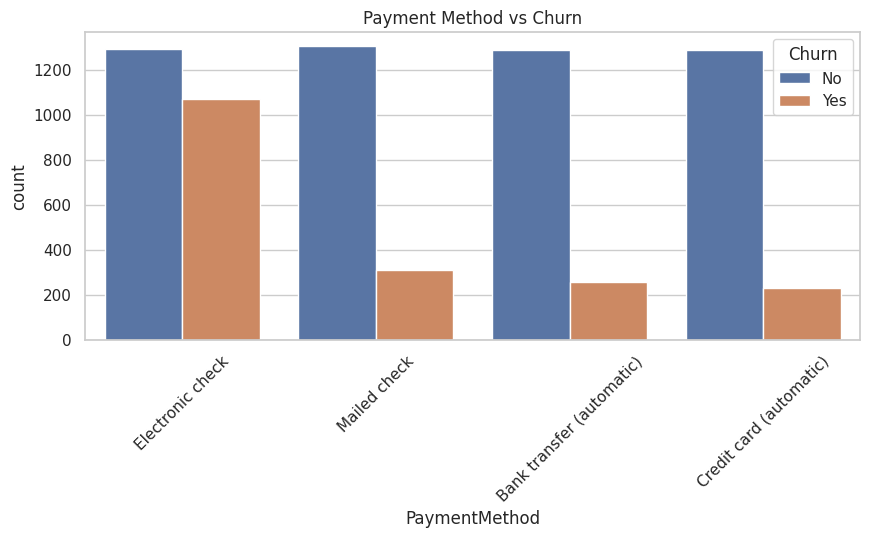

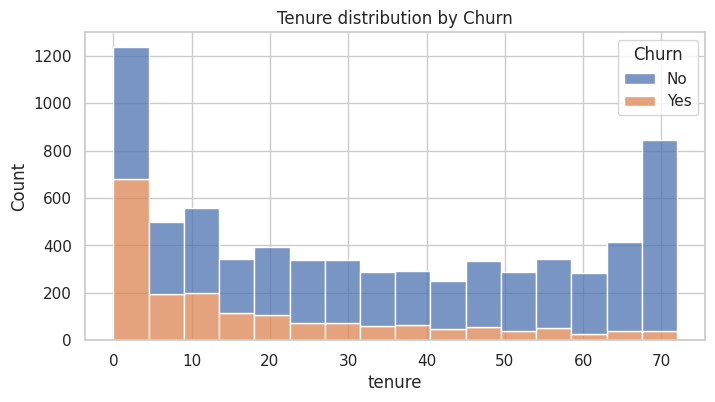

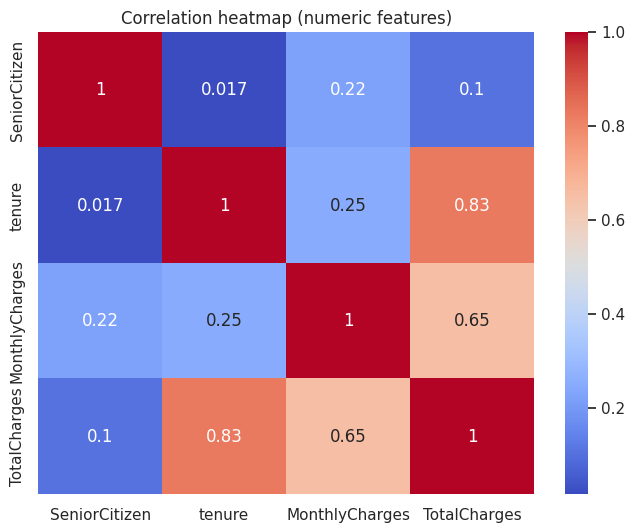

In [16]:
# ------------------------------
#  Exploratory plots
# ------------------------------
# Visual checks to understand relationships between features and churn

sns.set(style="whitegrid")

plt.figure(figsize=(6,4))
sns.countplot(x='gender', hue='Churn', data=dataset)
plt.title("Gender vs Churn")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='SeniorCitizen', hue='Churn', data=dataset)
plt.title("Senior Citizen vs Churn")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=dataset)
plt.title("MonthlyCharges by Churn")
plt.show()

plt.figure(figsize=(7,4))
sns.countplot(x='Contract', hue='Churn', data=dataset)
plt.title("Contract Type vs Churn")
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(x='PaymentMethod', hue='Churn', data=dataset)
plt.xticks(rotation=45)
plt.title("Payment Method vs Churn")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(data=dataset, x='tenure', hue='Churn', multiple='stack')
plt.title("Tenure distribution by Churn")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(dataset.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation heatmap (numeric features)")
plt.show()


In [17]:
# ------------------------------
#  Feature engineering
# ------------------------------
# Create a simple tenure group to capture non-linear tenure effects
tenure_breaks = [0, 12, 24, 36, 48, 60, np.inf]
tenure_names = ['0-12', '13-24', '25-36', '37-48', '49-60', '60+']

if 'tenure' in dataset.columns:
    dataset['tenure_group'] = pd.cut(dataset['tenure'], bins=tenure_breaks, labels=tenure_names, right=False)
    # Turn the tenure group into dummy variables and drop the first to avoid multicollinearity
    dataset = pd.get_dummies(dataset, columns=['tenure_group'], drop_first=True)
    print("Added tenure_group and applied one-hot encoding.")
else:
    print("Column 'tenure' not found; skipped tenure grouping.")

print("\nDataset information after feature engineering:")
dataset.info()

print("\nFirst 5 rows after feature engineering:")
print(dataset.head())


Added tenure_group and applied one-hot encoding.

Dataset information after feature engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7043 non-null   object 
 1   SeniorCitizen       7043 non-null   int64  
 2   Partner             7043 non-null   object 
 3   Dependents          7043 non-null   object 
 4   tenure              7043 non-null   int64  
 5   PhoneService        7043 non-null   object 
 6   MultipleLines       7043 non-null   object 
 7   InternetService     7043 non-null   object 
 8   OnlineSecurity      7043 non-null   object 
 9   OnlineBackup        7043 non-null   object 
 10  DeviceProtection    7043 non-null   object 
 11  TechSupport         7043 non-null   object 
 12  StreamingTV         7043 non-null   object 
 13  StreamingMovies     7043 non-null   object 
 14  Contrac

In [18]:
# ------------------------------
#  Encoding categorical variables and scaling
# ------------------------------
# Identify categorical and numerical columns
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()
numerical_columns = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

# Encode commonly categorical columns using LabelEncoder to keep things simple
le = LabelEncoder()
label_columns = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'Churn'
]

for col in label_columns:
    if col in dataset.columns:
        dataset[col] = le.fit_transform(dataset[col].astype(str))

# If any object-type columns remain, apply one-hot encoding to them
remaining_objects = [c for c in categorical_columns if c in dataset.columns and dataset[c].dtype == 'object']
if remaining_objects:
    dataset = pd.get_dummies(dataset, columns=remaining_objects, drop_first=True)
    print("One-hot encoded remaining columns:", remaining_objects)
else:
    print("No remaining object-type categorical columns to one-hot encode.")

# Remove target from scaling list
if 'Churn' in numerical_columns:
    numerical_columns = [c for c in numerical_columns if c != 'Churn']

# Standardize numeric columns to improve model convergence
scaler = StandardScaler()
if numerical_columns:
    dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])
    print("Scaled numeric features.")
else:
    print("No numeric features available for scaling.")

print("Dataset shape after encoding and scaling:", dataset.shape)
display(dataset.head())


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
No remaining object-type categorical columns to one-hot encode.
Scaled numeric features.
Dataset shape after encoding and scaling: (7043, 25)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group_13-24,tenure_group_25-36,tenure_group_37-48,tenure_group_49-60,tenure_group_60+
0,0,-0.439916,1,0,-1.277445,0,1,0,0,2,...,1,2,-1.160323,-0.994242,0,False,False,False,False,False
1,1,-0.439916,0,0,0.066327,1,0,0,2,0,...,0,3,-0.259629,-0.173244,0,False,True,False,False,False
2,1,-0.439916,0,0,-1.236724,1,0,0,2,2,...,1,3,-0.362660,-0.959674,1,False,False,False,False,False
3,1,-0.439916,0,0,0.514251,0,1,0,2,0,...,0,0,-0.746535,-0.194766,0,False,False,True,False,False
4,0,-0.439916,0,0,-1.236724,1,0,1,0,0,...,1,2,0.197365,-0.940470,1,False,False,False,False,False


In [19]:
# ------------------------------
# Cell 8a — Model Training
# ------------------------------
print("Starting model training...\n")

# Separate features and target variable
features = dataset.drop('Churn', axis=1)
target = dataset['Churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)
print(f"Data split complete: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples.")

# Define models to train
model_dict = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

# Train each model and save instances
trained_models = {}
for model_name, model_instance in model_dict.items():
    print(f"Training {model_name}...")
    model_instance.fit(X_train, y_train)
    trained_models[model_name] = model_instance

print("\nAll models have been trained successfully.")


Starting model training...

Data split complete: 5634 training samples, 1409 testing samples.
Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...

All models have been trained successfully.


Evaluating models...

Logistic Regression Accuracy: 0.8041
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



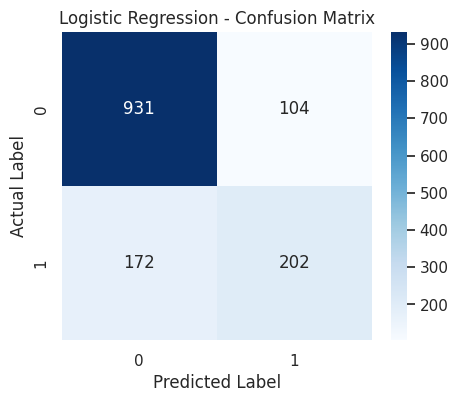

Random Forest Accuracy: 0.7949
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.50      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.79      1409



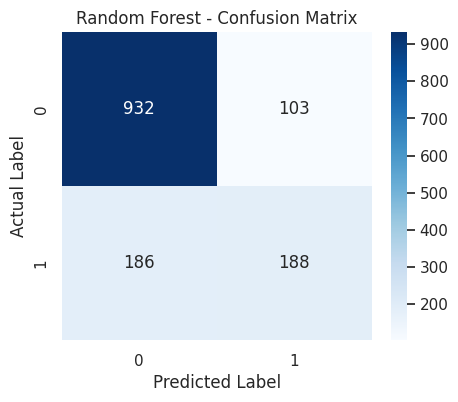

Gradient Boosting Accuracy: 0.8041
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



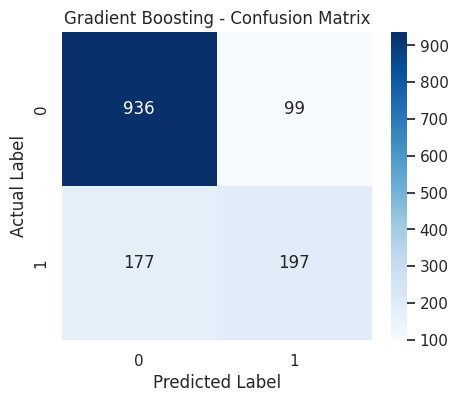


Model Accuracy Comparison:
Logistic Regression: 0.8041
Random Forest: 0.7949
Gradient Boosting: 0.8041

Best Performing Model: Logistic Regression with Accuracy = 0.8041


In [20]:
# ------------------------------
# Cell 8b — Model Evaluation
# ------------------------------
print("Evaluating models...\n")

# Dictionary to store evaluation results
model_results = {}

# Evaluate each trained model
for model_name, model_instance in trained_models.items():
    predictions = model_instance.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Print detailed classification report
    print("Classification Report:\n", classification_report(y_test, predictions))

    # Save the accuracy for comparison
    model_results[model_name] = accuracy

    # Plot confusion matrix for visual inspection
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

# Compare models based on accuracy
print("\nModel Accuracy Comparison:")
for name, acc in model_results.items():
    print(f"{name}: {acc:.4f}")

# Identify the best performing model
best_model_name = max(model_results, key=model_results.get)
print(f"\nBest Performing Model: {best_model_name} with Accuracy = {model_results[best_model_name]:.4f}")
